In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import joblib

In [15]:
# 1. Preprocessing Pipeline
def preprocess_data(train_path, test_path):
    # Load datasets
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    # Log transform revenue
    train_df['log_revenue'] = np.log1p(train_df['revenue'])
    test_df['log_revenue'] = np.log1p(test_df['revenue'])

    # Update the genre feature columns (assuming they are from 'War' to 'Horror')
    genre_features = train_df.loc[:, 'War':'Horror'].columns.tolist()
    features = [
        'budget', 'popularity', 'runtime', 'vote_average', 'vote_count',
        'release_year', 'release_month', 'release_day', 'collection_id',
        'director_score', 'actor_score'
    ] + genre_features

    # Apply StandardScaler to numerical features
    scaler = StandardScaler()
    numerical_features = ['budget', 'popularity', 'runtime', 'vote_average', 'vote_count', 'director_score', 'actor_score']
    train_df[numerical_features] = scaler.fit_transform(train_df[numerical_features])
    test_df[numerical_features] = scaler.transform(test_df[numerical_features])

    # Save scaler for future use
    # joblib.dump(scaler, 'scaler.pkl')

    # Return preprocessed data and feature list
    return train_df, test_df, features

In [16]:
# 2. Model Training Pipeline
def train_model(X_train, y_train, model_params=None):
    # Set default model parameters if none are provided
    if model_params is None:
        model_params = {'n_estimators': 100, 'random_state': 42}

    # Initialize and train the model
    model = RandomForestRegressor(**model_params)
    model.fit(X_train, y_train)

    # Save the trained model
    # joblib.dump(model, 'series_movie_revenue_predictor.pkl')

    return model


In [17]:
# Step 3: Model Evaluation and Visualization Pipeline
def evaluate_model(model, X_test, y_test_log):
    # Predict on the test set (log scale)
    y_test_pred_log = model.predict(X_test)

    # Convert log predictions and actual values back to original scale
    y_test_pred = np.expm1(y_test_pred_log)
    y_test_actual = np.expm1(y_test_log)

    # Calculate R2 score and MAE for test set
    test_r2 = r2_score(y_test_actual, y_test_pred)
    test_mae = mean_absolute_error(y_test_actual, y_test_pred)

    # Print evaluation metrics
    print(f"Test R2 Score: {test_r2}")
    print(f"Test Mean Absolute Error: {test_mae}")

    # Plot actual vs predicted values for visual comparison
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_actual, y_test_pred, alpha=0.5)
    plt.plot([y_test_actual.min(), y_test_actual.max()],
             [y_test_actual.min(), y_test_actual.max()],
             color='red', linestyle='--', linewidth=2)
    plt.xlabel('Actual Revenue')
    plt.ylabel('Predicted Revenue')
    plt.title('Actual vs Predicted Revenue for Test Set (Log Transformation Applied)')
    plt.show()


In [20]:
train_path = 'data/maindata_ver1.2_train.csv'
test_path = 'data/maindata_ver1.2_test.csv'

In [21]:
train_df, test_df, features = preprocess_data(train_path, test_path)

In [22]:
# Feature와 Target 분리
X_train = train_df[features]
y_train = train_df['log_revenue']
X_test = test_df[features]
y_test = test_df['log_revenue']

In [23]:
# Train the model
model = train_model(X_train, y_train)

Test R2 Score: 0.810737235981341
Test Mean Absolute Error: 54042427.62663876


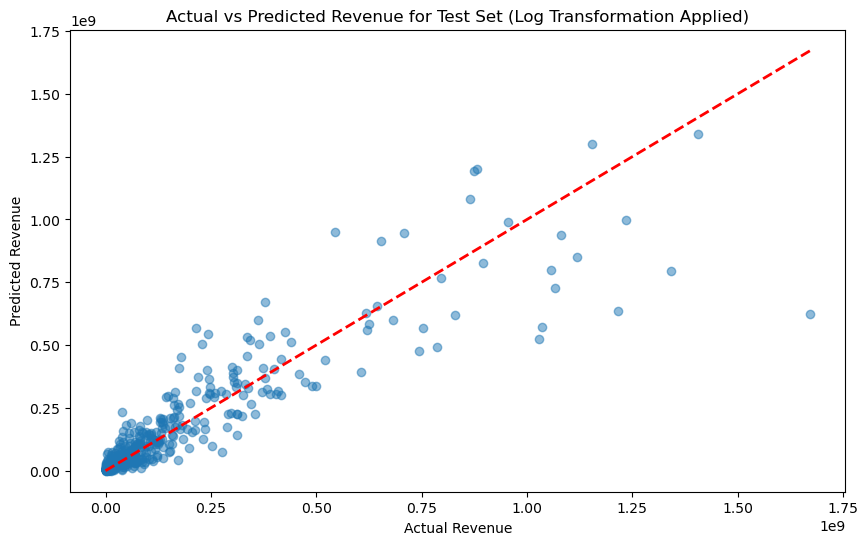

In [24]:
# Evaluate the model
evaluate_model(model, X_test, y_test)

- 우우.. 결과가 아쉽다..

In [12]:
average_revenue_train = train_df['revenue'].mean()
average_revenue_test = test_df['revenue'].mean()

print(f"Average Revenue in Train Set: {average_revenue_train}")
print(f"Average Revenue in Test Set: {average_revenue_test}")

Average Revenue in Train Set: 196749940.80628932
Average Revenue in Test Set: 153624568.11210763
